In [1]:
using_colab = False

In [2]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


In [3]:
np.random.seed(3)

def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

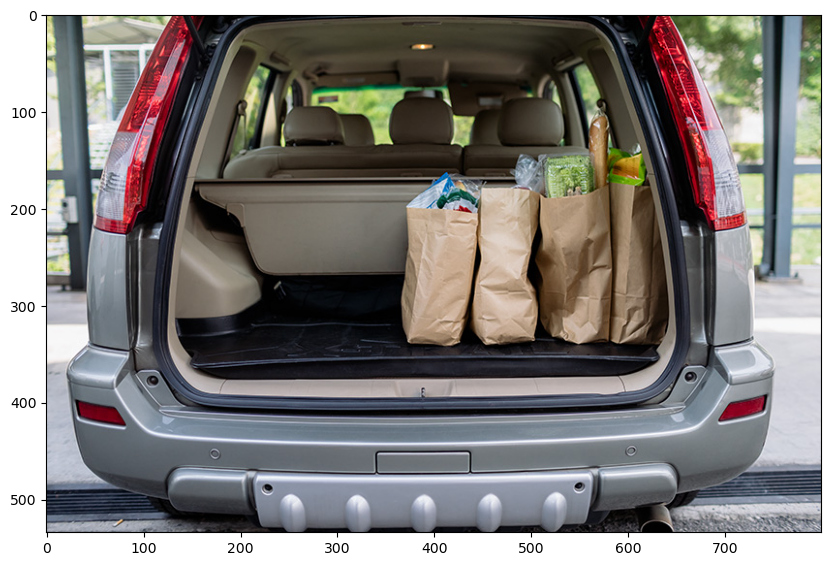

In [4]:
image = Image.open('images/groceries.jpg')
image = np.array(image.convert("RGB"))
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('on')
plt.show()

In [24]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection

os.environ["TORCH_CUDA_ARCH_LIST"] = "8.9"

mask_predictor = SAM2ImagePredictor.from_pretrained("facebook/sam2-hiera-large", device=device)
grounding_processor = AutoProcessor.from_pretrained("IDEA-Research/grounding-dino-base")
grounding_model = AutoModelForZeroShotObjectDetection.from_pretrained("IDEA-Research/grounding-dino-base").to(device)

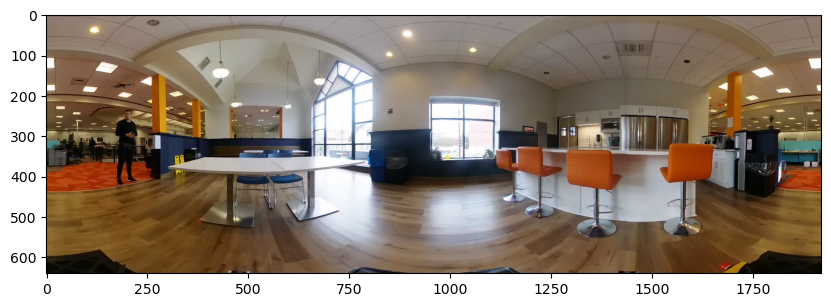

In [29]:
# load image
image = Image.open('/home/chadwick/Downloads/image/1697481994144161463.png')
image = np.array(image.convert("RGB"))
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('on')
plt.show()

In [40]:
object_list = ["table", "chair", "trash can"]
text_prompt = ". ".join(object_list) + "."
text_prompt

'table. chair. trash can.'

In [41]:
inputs = grounding_processor(
    images=image,
    text=text_prompt,
    return_tensors="pt",
).to(device)

In [49]:
import time

start = time.time()

for _ in range(100):

    with torch.no_grad():
        outputs = grounding_model(**inputs)
        
    results = grounding_processor.post_process_grounded_object_detection(
                outputs,
                inputs.input_ids,
                box_threshold=0.6,
                text_threshold=0.6,
                target_sizes=[image.shape[:2]]
    )
print(results)
print(f"Total time: {time.time() - start:.2f} s")

[{'scores': tensor([0.6876, 0.6663, 0.6183, 0.6893, 0.6109], device='cuda:0'), 'labels': ['table', 'chair', 'chair', 'chair', 'chair'], 'boxes': tensor([[ 301.0246,  345.4141,  791.1709,  527.6877],
        [1288.7286,  333.2660, 1427.0085,  554.0148],
        [ 544.7394,  334.5978,  645.7163,  477.4350],
        [1520.8811,  317.0290, 1658.8529,  550.6609],
        [1163.7849,  325.0002, 1279.2339,  504.6859]], device='cuda:0')}]
Total time: 8.70 s


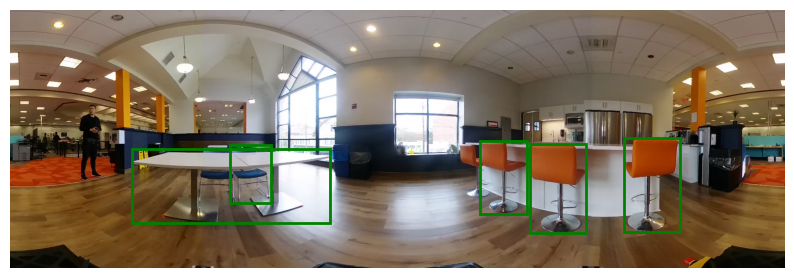

In [43]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
input_boxes = results[0]["boxes"].cpu().numpy()
for box in input_boxes:
    show_box(box, plt.gca())
    
plt.axis('off')
plt.show()

In [44]:
mask_predictor.set_image(image)

In [48]:
import time

start = time.time()

for _ in range(100):

    masks, scores, _ = mask_predictor.predict(
        point_coords=None,
        point_labels=None,
        box=input_boxes,
        multimask_output=False,
    )
print(f"Total time: {time.time() - start:.2f} s")

Total time: 0.65 s


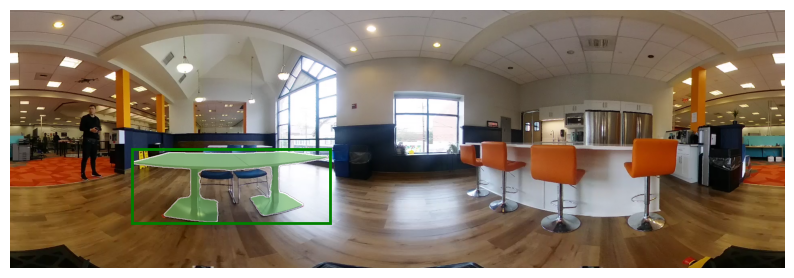

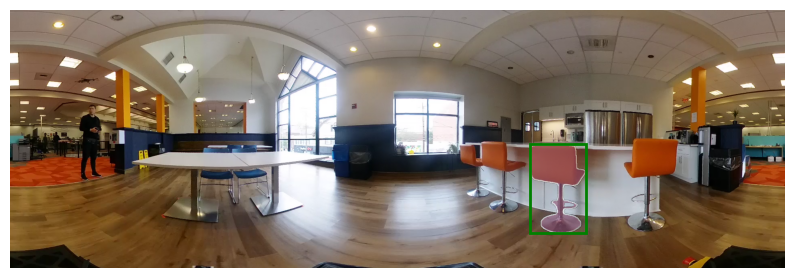

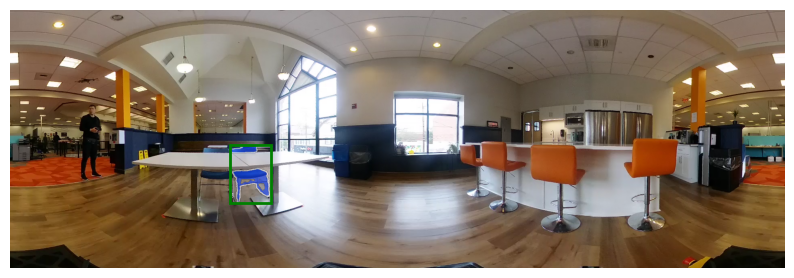

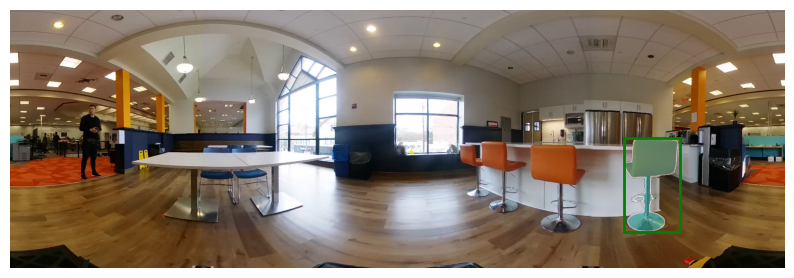

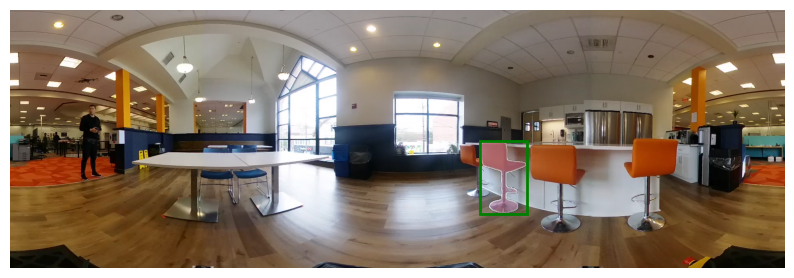

In [52]:
for mask, box in zip(masks, input_boxes):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)

    show_mask(mask.squeeze(0), plt.gca(), random_color=True)
    show_box(box, plt.gca())

    plt.axis('off')
    plt.show()